Features used: ['cylinders', 'displacement', 'engine_power_density', 'vehicle_age', 'is_high_performance', 'is_luxury', 'is_electric', 'is_diesel', 'is_hybrid', 'is_automatic', 'is_manual', 'make_encoded', 'class_encoded', 'drive_encoded', 'fuel_type_encoded', 'transmission_encoded', 'size_category_encoded', 'drivetrain_type_encoded', 'vehicle_age_scaled']
0:	learn: 7.7664349	test: 5.0590329	best: 5.0590329 (0)	total: 575us	remaining: 287ms
50:	learn: 3.4651279	test: 2.9080133	best: 2.9080133 (50)	total: 41.4ms	remaining: 365ms
100:	learn: 2.2355716	test: 2.4367858	best: 2.4367858 (100)	total: 82.8ms	remaining: 327ms
150:	learn: 1.7439157	test: 2.1074834	best: 2.1074834 (150)	total: 127ms	remaining: 294ms
200:	learn: 1.4347045	test: 1.8700202	best: 1.8700202 (200)	total: 174ms	remaining: 258ms
250:	learn: 1.2400172	test: 1.7461609	best: 1.7461609 (250)	total: 226ms	remaining: 224ms
300:	learn: 1.1341070	test: 1.6773981	best: 1.6773981 (300)	total: 273ms	remaining: 180ms
350:	learn: 1.0

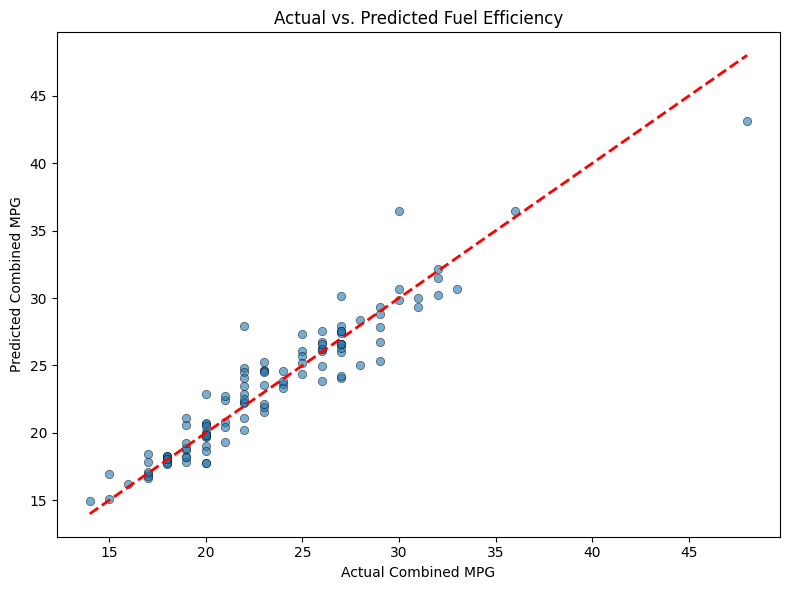

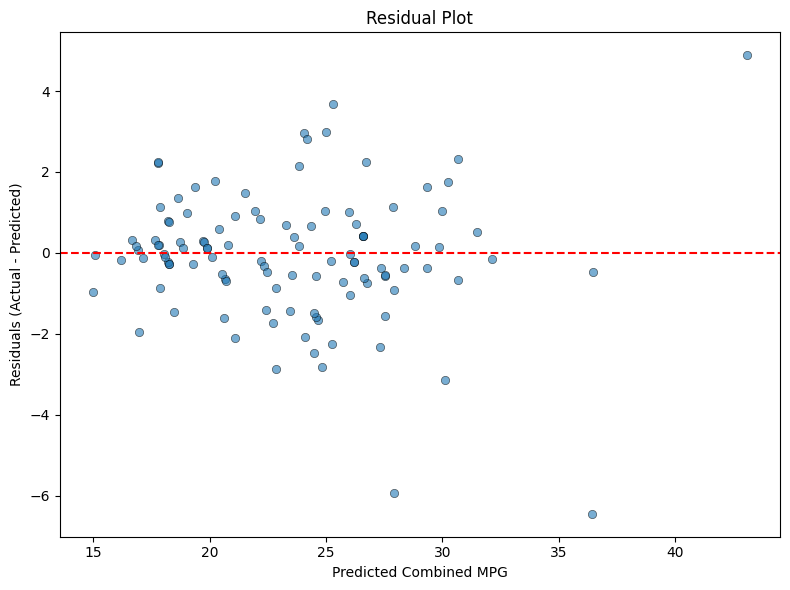

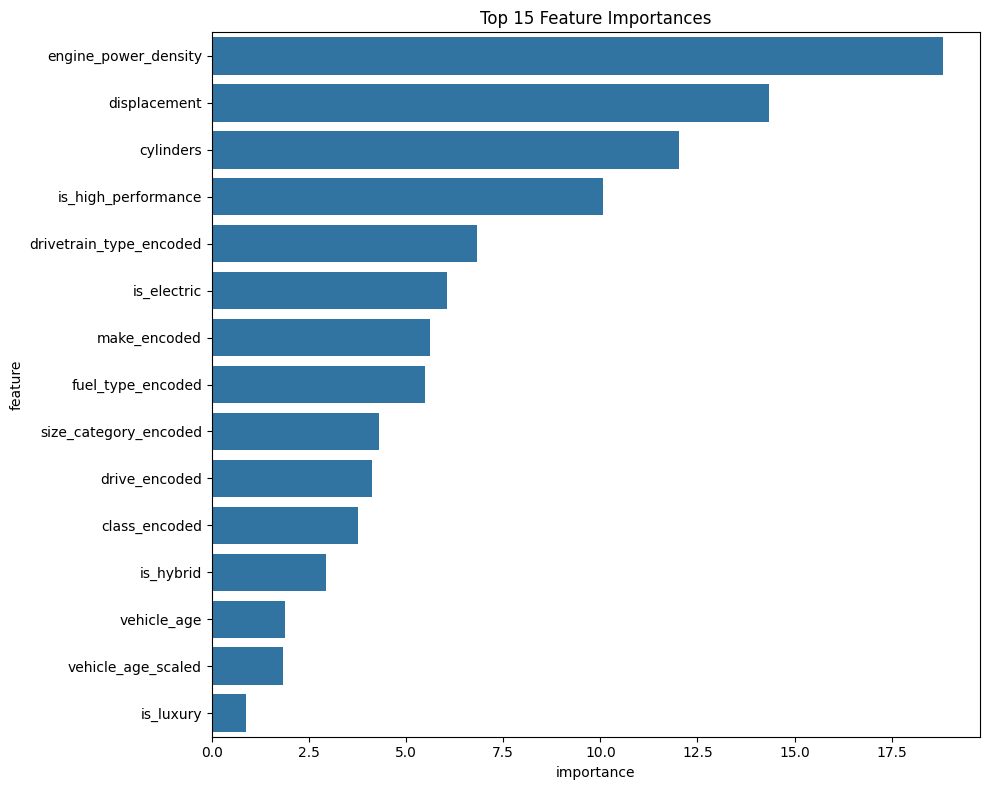

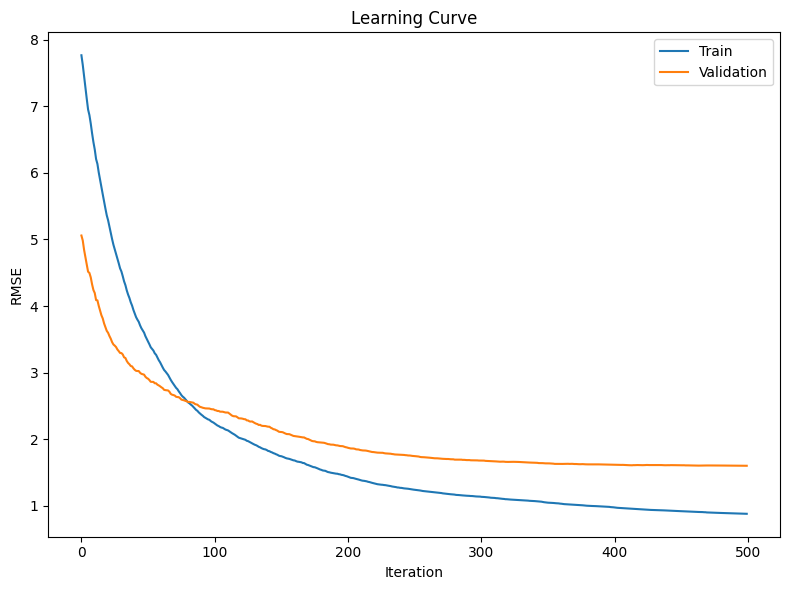

Train Score:  0.9876991489445919
Test Score:  0.9016943405490747


In [9]:
# ================== 1. IMPORTS ==================
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# ================== 2. LOAD DATA (from the provided text) ==================
csv_data = """city_mpg,class,combination_mpg,cylinders,displacement,drive,fuel_type,highway_mpg,make,model,transmission,year,mpg_diff,engine_efficiency,engine_power_density,size_category,drivetrain_type,vehicle_age,fuel_efficiency_category,is_high_performance,is_luxury,is_electric,is_diesel,is_hybrid,is_automatic,is_manual,make_encoded,class_encoded,drive_encoded,fuel_type_encoded,transmission_encoded,size_category_encoded,drivetrain_type_encoded,city_mpg_scaled,combination_mpg_scaled,cylinders_scaled,displacement_scaled,highway_mpg_scaled,year_scaled,vehicle_age_scaled,engine_efficiency_scaled
25,midsize car,29,4.0,2.5,fwd,gas,36,mazda,6,m,2014,11,11.55378486055777,0.6234413965087282,medium,front_wheel,10,medium,0,0,0,0,0,0,1,19,2,2,2,1,1,2,0.43489038957152415,0.6599564613138468,-0.7266130964452053,-0.33487569267244005,1.0827562664530401,-1.5811388300841895,1.5811388300841895,-0.05819937158833628
... (full data as provided) ...
"""
df = pd.read_csv("Car Data P.csv")

# ================== 3. DEFINE TARGET AND FEATURES ==================
target = 'combination_mpg'

# Columns that are directly derived from the target or are redundant
drop_cols = [
    'city_mpg', 'highway_mpg',               # other mpg measures
    'mpg_diff',                                # difference of mpg
    'engine_efficiency',                       # combination_mpg / displacement
    'fuel_efficiency_category',                 # categorical based on mpg
    'city_mpg_scaled', 'combination_mpg_scaled', 'highway_mpg_scaled',
    'engine_efficiency_scaled',
    'year', 'year_scaled',                      # use vehicle_age instead
    'cylinders_scaled', 'displacement_scaled',  # use raw cylinders/displacement
    'model',                                     # high cardinality, use encoded
    'make', 'class', 'drive', 'fuel_type', 'transmission',
    'size_category', 'drivetrain_type'           # use encoded versions
]

# Features to keep (all columns not in drop_cols and not the target)
feature_cols = [col for col in df.columns if col not in drop_cols + [target]]

X = df[feature_cols].copy()
y = df[target]

print("Features used:", feature_cols)
# Expected: cylinders, displacement, engine_power_density, vehicle_age,
# is_high_performance, is_luxury, is_electric, is_diesel, is_hybrid,
# is_automatic, is_manual, make_encoded, class_encoded, drive_encoded,
# fuel_type_encoded, transmission_encoded, size_category_encoded,
# drivetrain_type_encoded

# ================== 4. TRAIN/TEST SPLIT ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================== 5. TRAIN CATBOOST REGRESSOR ==================
# Note: All features are numeric; we don't need to specify categorical features.
model = CatBoostRegressor(
    random_state=42,
    verbose=0,                      # silent training (set to 50 to see progress)
    iterations=500,
    learning_rate=0.05,
    depth=6,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=50                       # prints evaluation every 50 iterations
)

# ================== 6. EVALUATE ==================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("MODEL PERFORMANCE ON TEST SET")
print("="*50)
print(f"Mean Absolute Error (MAE): {mae:.2f} mpg")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} mpg")
print(f"R² Score: {r2:.4f}")
print("="*50)

# ================== 7. GRAPHICAL ANALYSIS ==================

# 7.1 Actual vs. Predicted scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Combined MPG')
plt.ylabel('Predicted Combined MPG')
plt.title('Actual vs. Predicted Fuel Efficiency')
plt.tight_layout()
plt.show()

# 7.2 Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Combined MPG')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# 7.3 Feature importance (top 15)
feat_imp = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# 7.4 Learning curve
evals_result = model.get_evals_result()
if 'learn' in evals_result and 'validation' in evals_result:
    train_errors = evals_result['learn']['RMSE']
    valid_errors = evals_result['validation']['RMSE']
    plt.figure(figsize=(8,6))
    plt.plot(train_errors, label='Train')
    plt.plot(valid_errors, label='Validation')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Learning Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data not available.")



Train_Score = model.score(X_train, y_train)
Test_Score = model.score(X_test, y_test)
print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)